In [2]:
import sys
import tensorflow as tf
sys.path.append("/visuworks/Blindless_AIFFELTON/Ablation Study/")

# import customized modules
import preprocess, data_generator, check_result, metrics, loss, train

sys.path.append("/visuworks/Blindless_AIFFELTON/Ablation Study/Dense_Unet")
import dense_unet


# Insert Path
# {model_name}_{epoch}ep_{model_inpusize}_{Generator | aG/fG/sG}
FILE_NAME = 'dense_unet_50ep_512_sG_wo_slice'
INPUT_SHAPE = (512, 512, 1)
RESIZE_SHAPE = (1024, 1024, 1)
MODEL_PATH = "/visuworks/Blindless_AIFFELTON/Ablation Study/Dense_Unet/model_parameters/" + FILE_NAME + ".tf"
HISTORY_PATH = "/visuworks/Blindless_AIFFELTON/Ablation Study/Dense_Unet/history/" + FILE_NAME + '_history' ".json"

TRAIN_SOURCE = '/visuworks/Dataset/Selected Dataset 3/Train'
TEST_SOURCE = '/visuworks/Dataset/Selected Dataset 3/Test'

2024-02-15 05:34:15.052660: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 05:34:15.052688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 05:34:15.053723: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 05:34:15.059024: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 05:34:15.613676: W tensorflow/compiler/tf2

In [2]:
# Define custom objects for loading the model
custom_objects = {'DiceLoss': loss.DiceLoss(), 
                  'sensitivity': metrics.sensitivity,
                  'specificity': metrics.specificity,
                  'accuracy' : metrics.accuracy}


# Create augmentation
train_preproc = preprocess.build_augmentation_for_general(RESIZE_SHAPE[0], RESIZE_SHAPE[0])
test_preproc = preprocess.build_augmentation_for_general(RESIZE_SHAPE[0], RESIZE_SHAPE[0], is_train=False)

# Create train, test generator
train_generator = data_generator.SlicedDataGenerator(
    TRAIN_SOURCE, 
    number_of_images = 1,
    img_size=INPUT_SHAPE,
    output_size=INPUT_SHAPE,
    resize_shape = RESIZE_SHAPE,
    is_train=True,
    is_test=False,
    slice_black=False,
    augmentation= train_preproc
)

test_generator = data_generator.SlicedDataGenerator(
    TRAIN_SOURCE,
    number_of_images = 1,
    img_size=INPUT_SHAPE,
    output_size=INPUT_SHAPE,
    resize_shape = RESIZE_SHAPE,
    is_train=False,
    is_test=True,
    slice_black=False,
    augmentation= test_preproc
)

# Create model
model = dense_unet.build_model(input_shape=INPUT_SHAPE)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 48)         480       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 48)         192       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 48)         0         ['batch_normalization[0][0

2024-02-06 23:16:34.377426: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 23:16:34.411569: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 23:16:34.411789: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

 chNormalization)                                                                                 
                                                                                                  
 activation_2 (Activation)   (None, 256, 256, 112)        0         ['batch_normalization_2[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 256, 256, 240)        242160    ['activation_2[0][0]']        
                                                                                                  
 concatenate_2 (Concatenate  (None, 256, 256, 352)        0         ['conv2d_3[0][0]',            
 )                                                                   'max_pooling2d[0][0]']       
                                                                                                  
 batch_nor

In [ ]:
train.model_train(model,
                  epoch = 50,
                  train_generator = train_generator,
                  test_generator = test_generator,
                  model_path = MODEL_PATH,
                  history_path = HISTORY_PATH,
                  save_every_epoch=True,
                  apply_weight_decay=True)

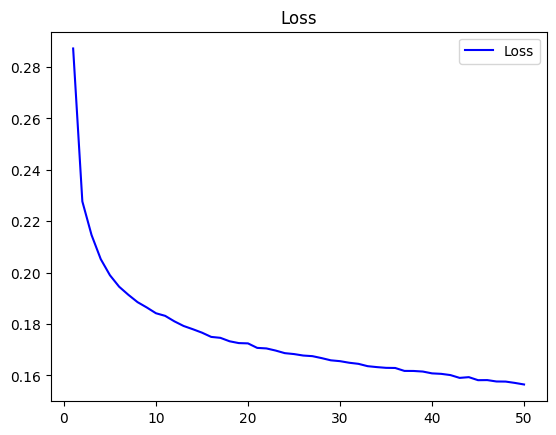

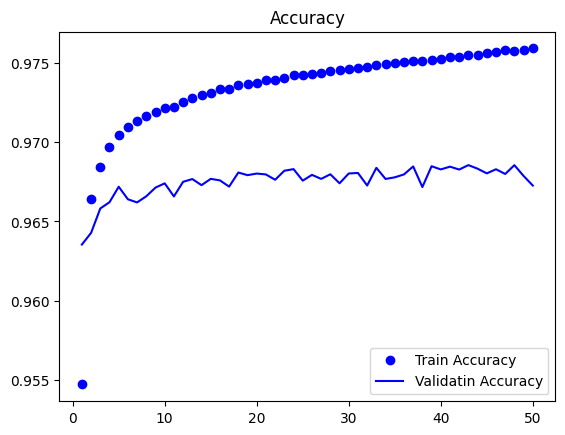

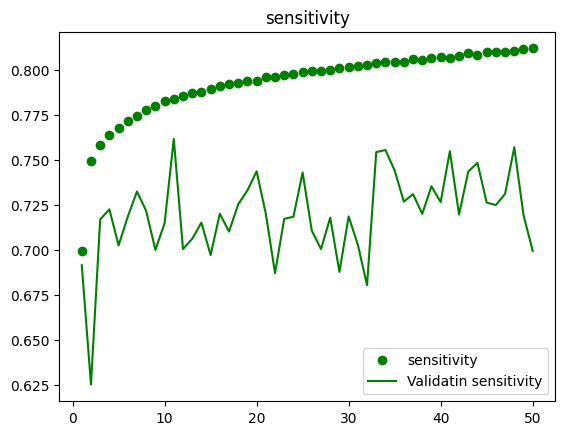

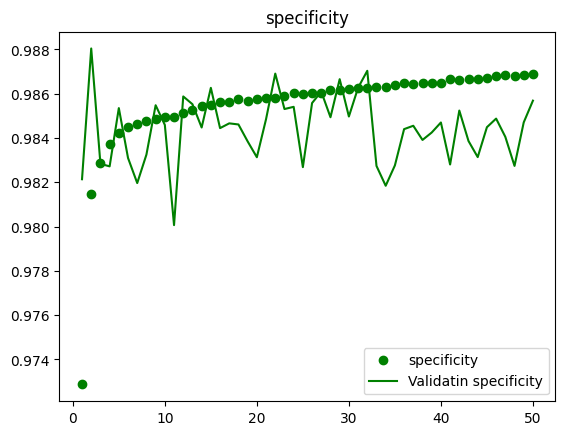

<Figure size 640x480 with 0 Axes>

In [4]:
check_result.plot_history(HISTORY_PATH)

In [3]:
custom_objects = {'DiceLoss': loss.DiceLoss(), 
                  'sensitivity': metrics.sensitivity,
                  'specificity': metrics.specificity,
                  'accuracy' : metrics.accuracy,
                  'f1_score' : metrics.f1_score,
                  'iou' : metrics.iou}

model_param_path = '/visuworks/Blindless_AIFFELTON/Ablation Study/Dense_Unet/model_parameters/dense_unet_50ep_512_sG_wo_slice.tf'
test_preproc = preprocess.build_augmentation_for_general(RESIZE_SHAPE[0], RESIZE_SHAPE[0], is_train=False)
test_generator = data_generator.SlicedDataGenerator(
    TEST_SOURCE,
    number_of_images = 1,
    img_size=INPUT_SHAPE,
    output_size=INPUT_SHAPE,
    resize_shape = RESIZE_SHAPE,
    is_train=False,
    is_test=True,
    slice_black=False,
    augmentation= test_preproc
)

loss, sen, spe, acc, f1, iou = metrics.retrive_all_evaluation_of_test_dataset(test_generator, model_param_path, custom_objects)

1번째 epoch 결과


2024-02-15 05:34:34.163932: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 05:34:34.198755: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 05:34:34.198954: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-02-15 05:34:36.384296: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


233/233 [==============================] - 19s 67ms/step - loss: 0.2397 - sensitivity: 0.7384 - specificity: 0.9802 - accuracy: 0.9637 - f1_score: 0.7233 - iou: 0.5788
2번째 epoch 결과
233/233 [==============================] - 16s 68ms/step - loss: 0.2533 - sensitivity: 0.6648 - specificity: 0.9876 - accuracy: 0.9653 - f1_score: 0.7099 - iou: 0.5615
3번째 epoch 결과
233/233 [==============================] - 16s 68ms/step - loss: 0.2220 - sensitivity: 0.7571 - specificity: 0.9813 - accuracy: 0.9658 - f1_score: 0.7403 - iou: 0.6003
4번째 epoch 결과
233/233 [==============================] - 16s 67ms/step - loss: 0.2212 - sensitivity: 0.7626 - specificity: 0.9809 - accuracy: 0.9659 - f1_score: 0.7423 - iou: 0.6034
5번째 epoch 결과
233/233 [==============================] - 16s 67ms/step - loss: 0.2171 - sensitivity: 0.7420 - specificity: 0.9842 - accuracy: 0.9675 - f1_score: 0.7455 - iou: 0.6069
6번째 epoch 결과
233/233 [==============================] - 16s 68ms/step - loss: 0.2214 - sensitivity: 0.7599 -

In [4]:
import pickle
# Save the metrics as a dictionary
metrics_dict = {
    'loss': loss,
    'sen': sen,
    'spe': spe,
    'acc': acc,
    'f1': f1,
    'iou': iou
}

# Define the file path
file_path = 'dense_unet_50ep_512_sG_wo_slice_metrics_data.pkl'

# Write the metrics to a file using pickle
with open(file_path, 'wb') as f:
    pickle.dump(metrics_dict, f)

In [5]:
file_path = 'dense_unet_50ep_512_sG_wo_slice_metrics_data.pkl'

# Load the metrics from the pickle file
with open(file_path, 'rb') as f:
    metrics_dict = pickle.load(f)

# Access the metrics from the loaded dictionary
loss = metrics_dict['loss']
sen = metrics_dict['sen']
spe = metrics_dict['spe']
acc = metrics_dict['acc']
f1 = metrics_dict['f1']
iou = metrics_dict['iou']

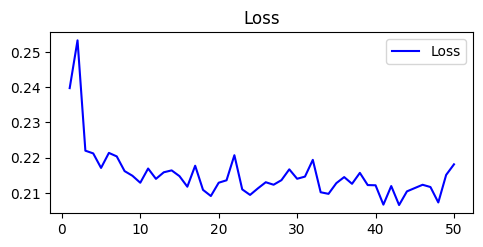

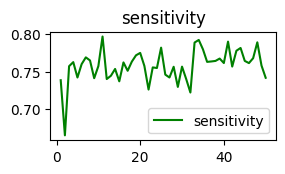

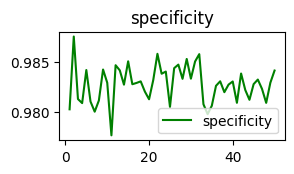

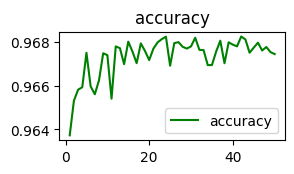

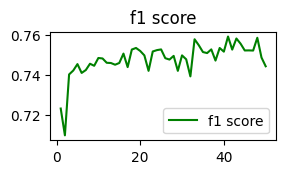

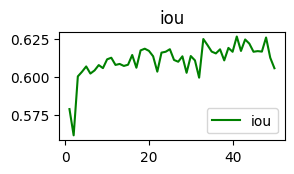

<Figure size 640x480 with 0 Axes>

In [6]:
metrics.plot_test_evaluation_result(loss, sen, spe, acc ,f1, iou)